# Simple forecasting of COVID-19 using exponential and sigmoid functions

This repo uses report COVID-19 data provided by the Johns Hopkins University Center for Systems Science and Engineering (JHU CSSE) to estimate near term COVID-19 death rates around the world.  


In [119]:
# COVID-19 forecasting - how will this impact NZ and NZ electricity demand in 2020?
import pandas as pd
%pylab inline
from datetime import date, datetime, time, timedelta
import matplotlib.dates as mdates
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.5/dist-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['time', 'datetime']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [121]:
# get some nice colours and define better legend and plot formatting...

c_p = {'rd2': (0.9647058823529412, 0.5450980392156862, 0.6352941176470588), 'yl1': (1.0, 0.7294117647058823, 0.17647058823529413), 'gy2': (0.9098039215686274, 0.9098039215686274, 0.9098039215686274), 'bl2': (0.7176470588235294, 0.8901960784313725, 0.9725490196078431), 'yl2': (0.984313725490196, 0.8196078431372549, 0.5450980392156862), 'br1': (0.32941176470588235, 0.0, 0.0), 'bl1': (0.058823529411764705, 0.4823529411764706, 0.6862745098039216), 'rd1': (0.9294117647058824, 0.09019607843137255, 0.27058823529411763), 'gy1': (0.8235294117647058, 0.8235294117647058, 0.8235294117647058), 'br2': (0.6627450980392157, 0.5019607843137255, 0.5019607843137255)}
c_s = {'og1': (0.8235294117647058, 0.38823529411764707, 0.10196078431372549), 'yl1': (0.803921568627451, 0.8156862745098039, 0.0), 'or1': (1.0, 0.4823529411764706, 0.0), 'pp1': (0.27058823529411763, 0.1803921568627451, 0.6745098039215687), 'mv1': (0.0, 0.4588235294117647, 0.4235294117647059), 'rd2': (0.8470588235294118, 0.5882352941176471, 0.5019607843137255), 'pr1': (0.803921568627451, 0.34901960784313724, 1.0), 'pk2': (1.0, 0.7372549019607844, 0.8313725490196079), 'gr1': (0.00784313725490196, 0.4666666666666667, 0.2196078431372549), 'or2': (1.0, 0.7372549019607844, 0.5019607843137255), 'mv2': (0.5019607843137255, 0.7254901960784313, 0.7098039215686275), 'pp2': (0.6862745098039216, 0.6431372549019608, 0.7411764705882353), 'gn1': (0.3803921568627451, 0.7372549019607844, 0.22745098039215686), 'bu1': (0.0, 0.5568627450980392, 1.0), 'bl2': (0.5254901960784314, 0.7372549019607844, 0.8392156862745098), 'ge1': (0.0, 0.7019607843137254, 0.6196078431372549), 'yl2': (0.8980392156862745, 0.9058823529411765, 0.5019607843137255), 'bu2': (0.5019607843137255, 0.7725490196078432, 1.0), 'ge2': (0.5019607843137255, 0.8470588235294118, 0.807843137254902), 'rd1': (0.7019607843137254, 0.18823529411764706, 0.0), 'gy1': (0.5843137254901961, 0.5843137254901961, 0.5843137254901961), 'og2': (0.8901960784313725, 0.6901960784313725, 0.5490196078431373), 'gy2': (0.788235294117647, 0.788235294117647, 0.788235294117647), 'be2': (0.8862745098039215, 0.9490196078431372, 0.984313725490196), 'pk1': (1.0, 0.3411764705882353, 0.9607843137254902), 'be1': (0.7803921568627451, 0.9019607843137255, 0.9803921568627451), 'gr2': (0.5019607843137255, 0.7294117647058823, 0.7098039215686275), 'bl1': (0.058823529411764705, 0.4823529411764706, 0.6862745098039216), 'gn2': (0.6862745098039216, 0.8666666666666667, 0.611764705882353), 'pr2': (0.8980392156862745, 0.6705882352941176, 1.0)}

def colours():
    mpl.rcParams['axes.prop_cycle'] = cycler('color', [c_p['br1'], c_p['br2'],
        c_p['bl1'], c_p['bl2'], c_p['yl1'], c_p['yl2'], c_p['rd1'], c_p['rd2'],
        c_p['gy1'], c_p['gy2'], c_s['pp1'], c_s['pp2'], c_s['pr1'], c_s['pr2'],
        c_s['gr1'], c_s['gr2'], c_s['gn1'], c_s['gn2'], c_s['pk1'], c_s['pk2'],
        c_s['yl1'], c_s['yl2'], c_s['mv1'], c_s['mv2']])

def legend_format(ax, cols=4, xpos=-0.021, ypos=-0.15, **kwargs):
    """Place legend outside of plot"""
    ax.legend(loc=3,
              bbox_to_anchor=(xpos, ypos),
              ncol=cols,
              frameon=False, **kwargs)

def plot_formatting(ax, rot=False, **kwargs):
    """A few tricks used for better looking plots"""
    ax.grid(b=True, which='major', color='k', linestyle='-',
            axis='y', alpha=0.6, clip_on=True, marker=None)
    ax.grid(b=False, axis='x', which='both')
    ax.set_frame_on(False)  # Remove plot frame
    ax.set_axisbelow(True)
    ax.xaxis.tick_bottom()
    plt.xticks(ax.get_xticks(), rotation=0, **kwargs)
    if rot:
        plt.xticks(ax.get_xticks(), rotation=90, **kwargs)
    else:
        plt.xticks(ax.get_xticks(), rotation=0, **kwargs) 
    
colours()

In [122]:
# Update data from the Johns Hopkins University Center for Systems Science and
# Engineering (JHU CSSE) github repo
#!git pull upstream master

In [123]:
# Read into Pandas DataFrames
#d_ts = pd.read_csv('csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Deaths.csv', index_col=[0, 1, 2, 3], parse_dates=True)
c_ts = pd.read_csv('csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv', index_col=[0, 1, 2, 3], parse_dates=True)
r_ts = pd.read_csv('csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv', index_col=[0, 1, 2, 3], parse_dates=True)
d_ts = pd.read_csv('csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv', index_col=[0, 1, 2, 3], parse_dates=True)
# Convert columns to datetime objects
d_ts.columns = pd.to_datetime(d_ts.columns)
c_ts.columns = pd.to_datetime(c_ts.columns)
r_ts.columns = pd.to_datetime(r_ts.columns)

d_ts = d_ts.groupby(level=1, axis=0).sum().T
c_ts = c_ts.groupby(level=1, axis=0).sum().T
r_ts = r_ts.groupby(level=1, axis=0).sum().T
d_ts.loc["2020-03-12", "Italy"] = np.nan 
d_ts = d_ts.interpolate()

# China
C_D = d_ts["China"]
C_C = c_ts["China"]
C_R = r_ts["China"]

# RoW
RoW_D = d_ts.drop('China', axis=1).sum(axis=1)
RoW_C = c_ts.drop('China', axis=1).sum(axis=1)
RoW_R = r_ts.drop('China', axis=1).sum(axis=1)


RoW_D2 = d_ts.drop('China', axis=1)
RoW_D2.loc['2020-03-12', 'Italy']=np.nan
RoW_D2 = RoW_D2.interpolate()
RoW_D = RoW_D2.sum(axis=1)

In [124]:
RoW_D2.tail()

Country/Region,Afghanistan,Albania,Algeria,Andorra,Angola,Antigua and Barbuda,Argentina,Armenia,Australia,Austria,...,Ukraine,United Arab Emirates,United Kingdom,Uruguay,Uzbekistan,Venezuela,Vietnam,West Bank and Gaza,Zambia,Zimbabwe
2020-03-22,1,2,17,1,0,0,4,0,7,16,...,3,2,282,0,0,0,0,0,0,0
2020-03-23,1,4,17,1,0,0,4,0,7,21,...,3,2,336,0,0,0,0,0,0,1
2020-03-24,1,5,19,1,0,0,6,0,8,28,...,3,2,423,0,0,0,0,0,0,1
2020-03-25,2,5,21,1,0,0,8,0,8,30,...,5,2,466,0,0,0,0,0,0,1
2020-03-26,4,6,25,3,0,0,9,1,13,49,...,5,2,580,0,0,0,0,1,0,1


In [125]:
def fit_exp(df, start_date=datetime(2020, 1, 21), end_date=datetime(2020, 4, 20)):
    """Simple exponential forecast - essentially a straight line fit of the logs.
       This massively over estimates things in the long run but may be reasonably 
       accurate while in the early exponential phase of a pandemic.  It is still good to
       use to help see when we are deviating from the exponential"""
    def initialise_forecast(df, start_date=start_date, end_date=end_date):
        """given actual reported death rate data, start time, and forecast end time, return cropped reported data and forecast date range for forecasting"""
        df = df[start_date:]
        df = df.replace(0, np.nan).dropna()
        dates = list(df.index)
        date_forecast = pd.date_range(start_date, end_date).to_pydatetime()
        x = mdates.date2num(dates)
        x_forecast = mdates.date2num(date_forecast)
        return df, dates, x, x_forecast

    df, dates, x, x_forecast = initialise_forecast(df, start_date=start_date, end_date=end_date)
    ydata = df.values
    df_reported = pd.DataFrame({'Date': x, 'Reported': ydata})
    df_reported.set_index('Date', inplace=True)

    y = log(ydata)
    p4 = np.poly1d(np.polyfit(x, y, 1))

    xx = np.linspace(x.min(), x.max(), 100)
    xx_forecast = np.linspace(x_forecast.min(), x_forecast.max(), 1000)
    dd = mdates.num2date(xx)
    dd_forecast = mdates.num2date(xx_forecast)

    df = pd.DataFrame({'Date': dd, 'Fitted': exp(p4(xx))})
    df_reported = pd.DataFrame({'Date': dates, 'Reported': ydata})
    df.set_index('Date', inplace=True)
    df_reported.set_index('Date', inplace=True)
    df_forecast = pd.DataFrame({'Date': dd_forecast,
                                'Forecast': exp(p4(xx_forecast))})
    df_forecast.set_index('Date', inplace=True)
    df_forecast.index = df_forecast.index.map(lambda x: x.date())
    df_forecast = df_forecast.groupby(level=0).min()
    df_p = pd.DataFrame({'Reported': df_reported.Reported,
                        'Forecast': df_forecast.Forecast}, index=df_forecast.index)

    df_p.index = pd.to_datetime(df_p.index)
    return df_p

In [126]:
# define some functions we will use to curve fit and forecast COVID-19 deaths...

def fit_sigmoid(df, start_date=datetime(2020, 1, 21), end_date=datetime(2020, 3, 31),
                p0=None):
    """Attempt to fit a sigmoid function to actual data, the outputs (popt, pcov) 
       are then used in forecast..."""

    def sigmoid(x, L ,x0, k, b):
        """https://stackoverflow.com/questions/55725139/fit-sigmoid-function-s-shape-curve-to-data-using-python"""
        y = L / (1 + np.exp(-k*(x-x0)))+b
        return (y)

    def initialise_forecast(df, start_date=start_date, end_date=end_date):
        """given actual reported death rate data, start time, and forecast end time, return cropped reported data and forecast date range for forecasting"""
        df = df[start_date:]
        dates = list(df.index)
        date_forecast = pd.date_range(start_date, end_date).to_pydatetime()
        x = mdates.date2num(dates)
        x_forecast = mdates.date2num(date_forecast)
        return df, x, x_forecast

    df, x, x_forecast = initialise_forecast(df, start_date=start_date, end_date=end_date)
    dates = list(df.index)
    xdata = mdates.date2num(dates)
    ydata = df.values
    df_reported = pd.DataFrame({'Date': dates, 'Reported': ydata})
    df_reported.set_index('Date', inplace=True)

    if not p0:
        p0 = [max(ydata), np.median(xdata),1,min(ydata)] # this is an mandatory initial guess
    print(p0)
    popt, pcov = curve_fit(sigmoid, xdata, ydata,p0, method='dogbox')
    
    y_forecast = sigmoid(x_forecast, *popt)
    
    xx_forecast = pd.to_datetime(mdates.num2date(x_forecast))
    xx_forecast = xx_forecast.map(lambda x: x.date())

    
    
    df_p = pd.DataFrame({'Forecast': y_forecast, 
                        'Reported': df_reported.Reported}, index=xx_forecast)
    df_p.index = pd.to_datetime(df_p.index)
    return df_p  #y_forecast, xx_forecast


### China death rate data follows a sigmoid (S-curve function)

https://stackoverflow.com/questions/55725139/fit-sigmoid-function-s-shape-curve-to-data-using-python

https://en.wikipedia.org/wiki/Logistic_function

We need to fit to this, then apply to the RoW data.

Chinese data looks like topping out at <4000 total deaths.  

But China was aggressive with containment, so this might be a best case scenario when applied to the rest of the world.


[3291, 737478.0, 1, 17]
[3291, 737478.0, 1, 17]
[3291, 737478.0, 1, 17]


/usr/local/lib/python3.5/dist-packages/scipy/optimize/_lsq/dogbox.py:225: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  newton_step = lstsq(J_free, -f)[0]
/home/humed/.local/lib/python3.5/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in log
  del sys.path[0]


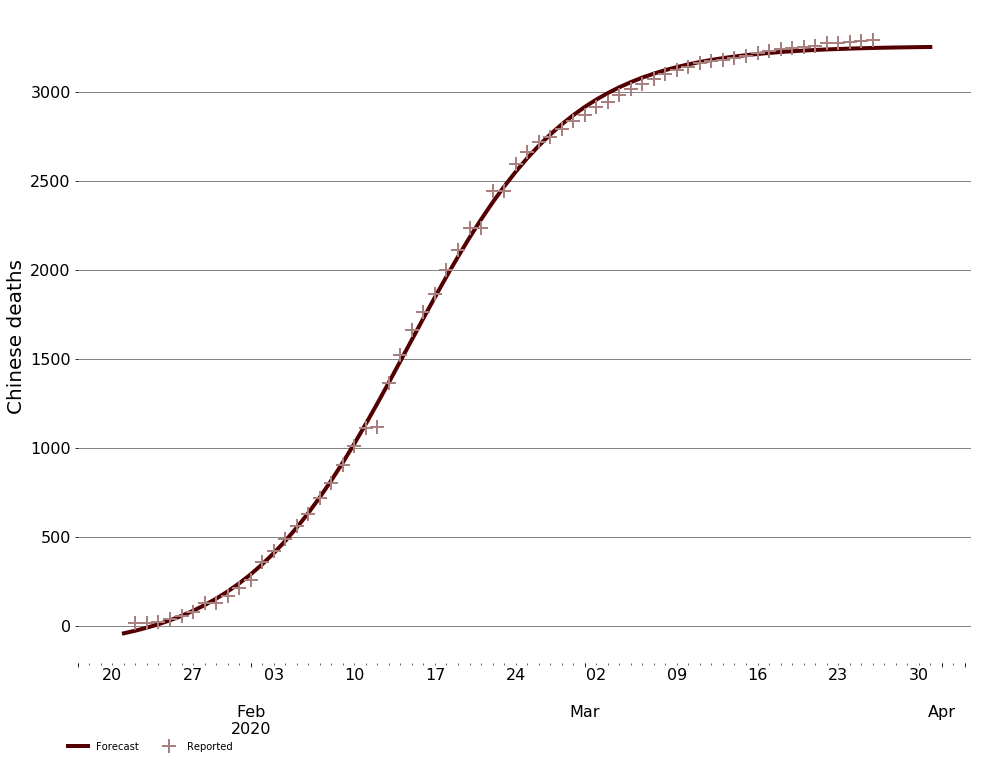

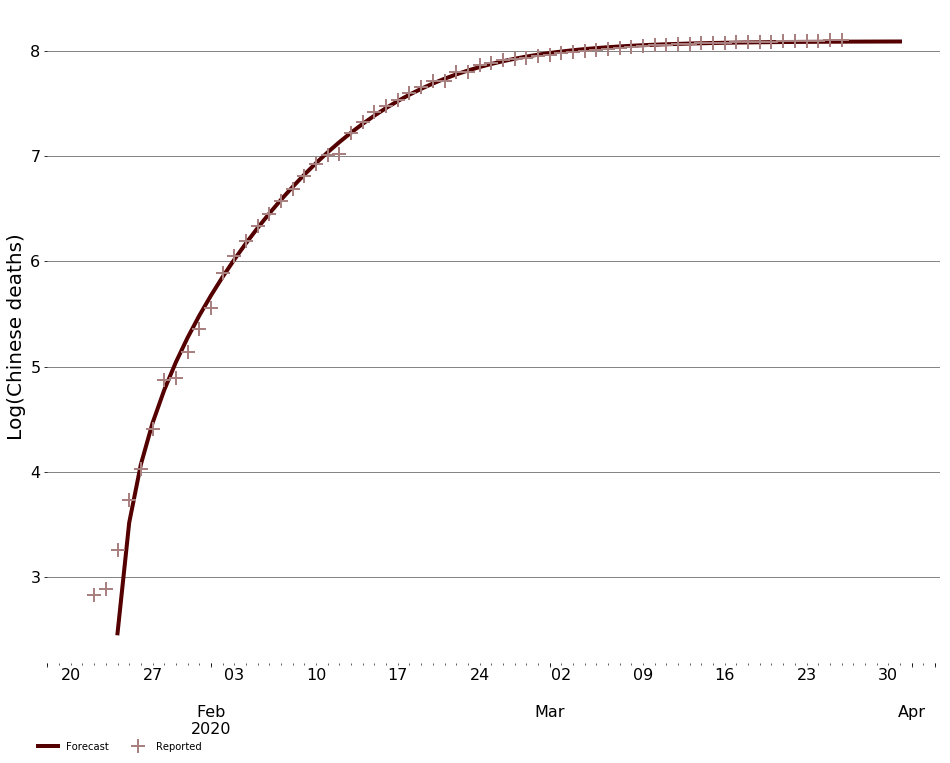

In [127]:
fig = plt.figure(1, figsize=[16,12])
ax = fig.add_subplot(111)
C_D_fitted = fit_sigmoid(C_D)
C_D_fitted.Forecast.plot(ax=ax, lw=4, fontsize=16, label='Forecast')
C_D_fitted.Reported.plot(ax=ax, marker="+", lw=0, ms=14, mew=2, label='Reported')
grid('on')
ax.set_ylabel('Chinese deaths', fontsize=20)
legend_format(ax)
plot_formatting(ax)

fig = plt.figure(2, figsize=[16,12])
ax = fig.add_subplot(111)
log(fit_sigmoid(C_D).Forecast).plot(ax=ax, lw=4, fontsize=16)
log(fit_sigmoid(C_D).Reported).plot(ax=ax, marker="+", lw=0, ms=14, mew=2)
ax.set_ylabel('Log(Chinese deaths)', fontsize=20)
grid('on')

legend_format(ax)
plot_formatting(ax)

## Rest of World data

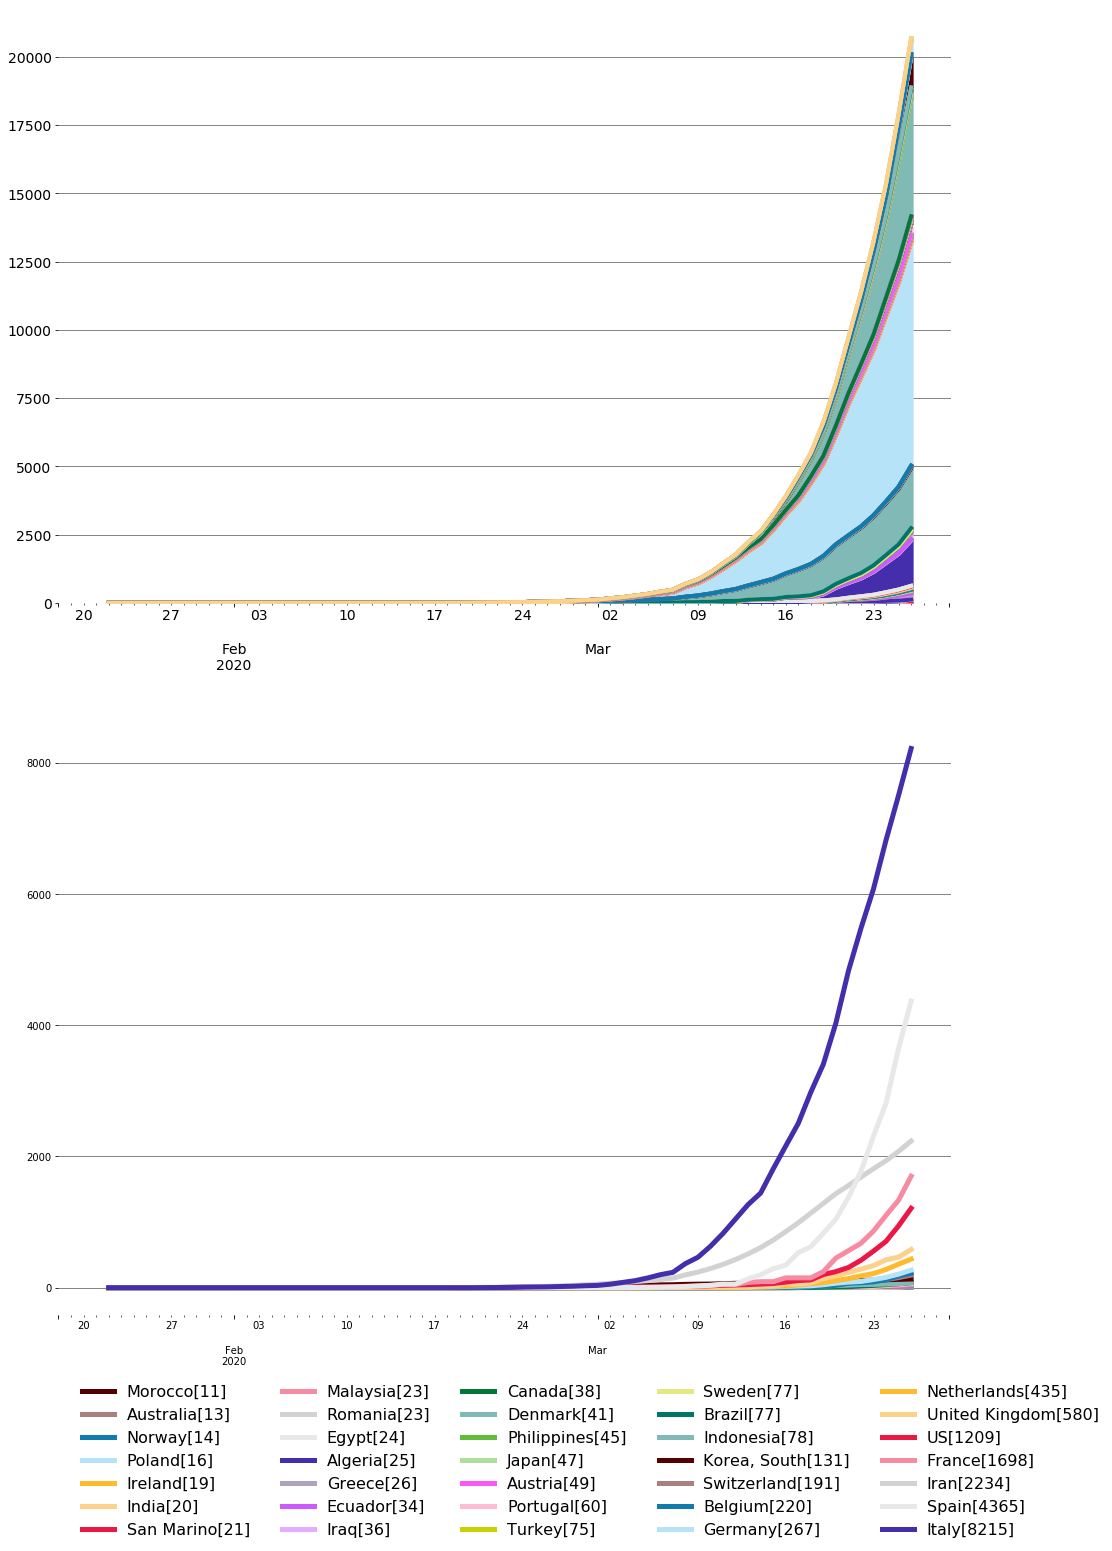

In [181]:
RoW_D3 = RoW_D2.loc[:, RoW_D2.sum(axis=0)>0]

fig = plt.figure(1, figsize=[16,24])
ax = fig.add_subplot(211)
RoW_D3.plot(kind='area', ax=ax, lw=4, fontsize=14)
ax.get_legend().remove()
plot_formatting(ax)
ax2 = fig.add_subplot(212)
RoW_DDno = RoW_D3.copy()
RoW_DDno.columns = RoW_D3.iloc[-1,:].reset_index().apply(lambda x: x[0] + '[' + str(int(x[1])) + ']', axis=1)
RoW_DD100 = RoW_DDno.loc[:, RoW_DDno.iloc[-1,:]>10]
RoW_DD100 = RoW_DD100[RoW_DD100.iloc[-1, :].sort_values().index]
#RoW_DD100 = RoW_DD100.iloc[-1, :].sort_values()
RoW_DD100.plot(ax=ax2, lw=5)
plot_formatting(ax2)
legend_format(ax2, cols=5, ypos=-0.4, xpos=0.01, fontsize=16)


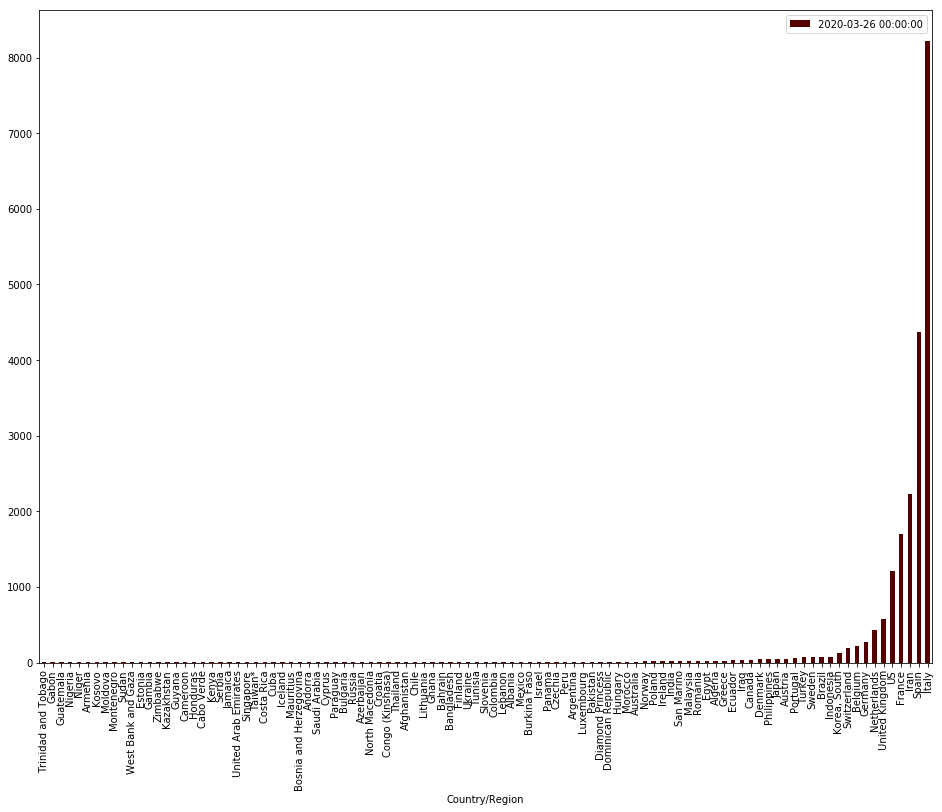

In [182]:
Cur_total_deaths = RoW_D2.tail(1).T.sort_values(by=RoW_D2.tail(1).T.columns[0])
fig = plt.figure(1, figsize=[16,12])
ax = fig.add_subplot(111)
Cur_total_deaths[Cur_total_deaths.sum(axis=1)>0].plot(kind='bar', ax=ax)

(0, 10000)

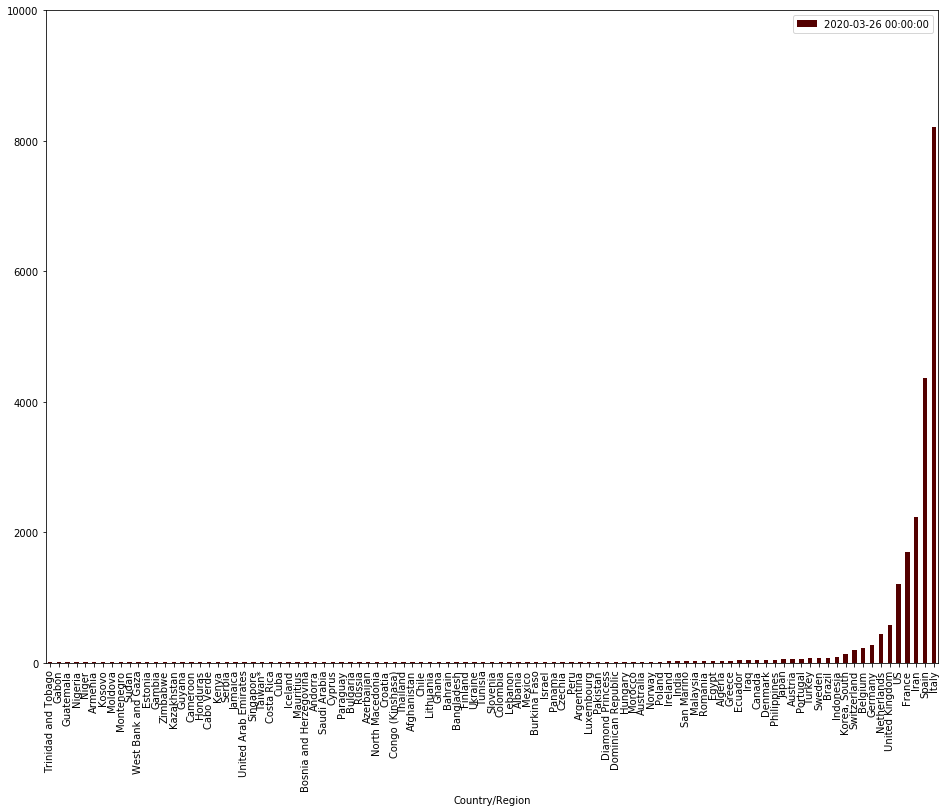

In [183]:
Cur_total_deaths = RoW_D2.tail(1).T.sort_values(by=RoW_D2.tail(1).T.columns[0])
fig = plt.figure(1, figsize=[16,12])
ax = fig.add_subplot(111)
Cur_total_deaths[Cur_total_deaths.sum(axis=1)>0].plot(kind='bar', ax=ax)
ax.set_ylim([0, 10000])

In [184]:
RoW_D.tail()

2020-03-22    11377.0
2020-03-23    13231.0
2020-03-24    15344.0
2020-03-25    17896.0
2020-03-26    20679.0
dtype: float64

/home/humed/.local/lib/python3.5/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


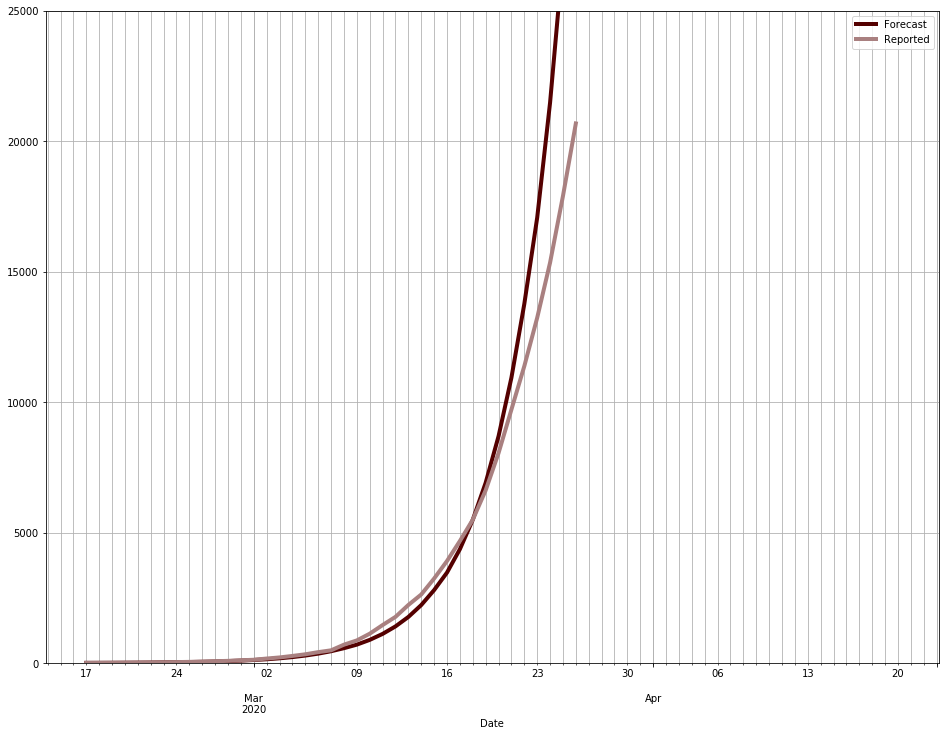

In [185]:
fig = plt.figure(1, figsize=[16,12])
ax = fig.add_subplot(111)
fit_exp(RoW_D, start_date=datetime(2020,2,17)).plot(ax=ax, lw=4)
ax.set_ylim([0, 25000])
grid('on', which='both')

/home/humed/.local/lib/python3.5/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


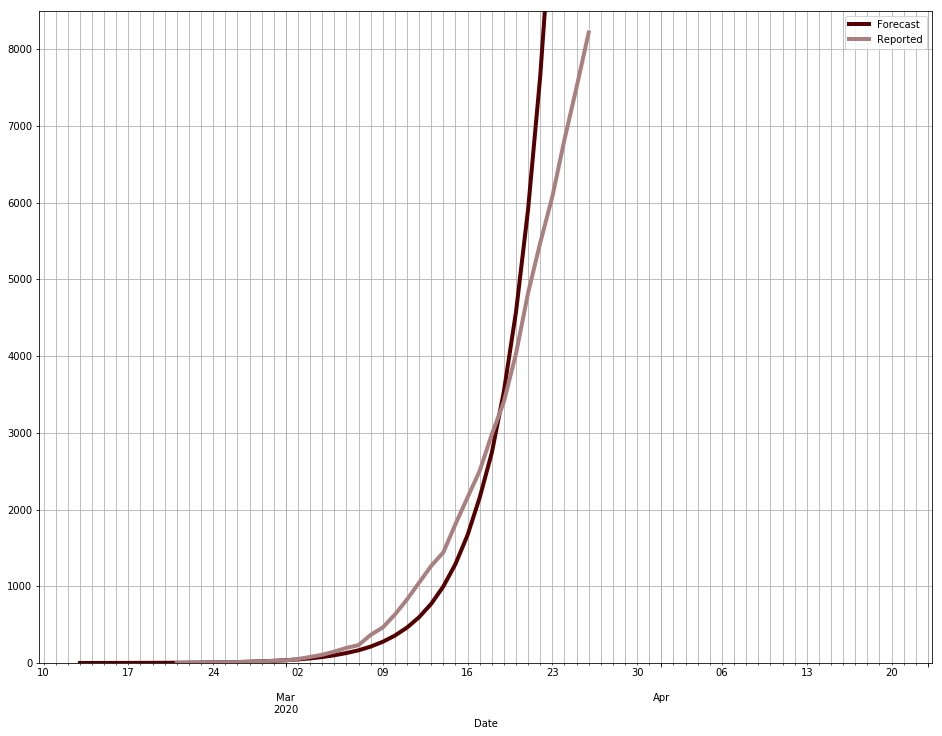

In [186]:
fig = plt.figure(1, figsize=[16,12])
ax = fig.add_subplot(111)
fit_exp(RoW_D2['Italy'], start_date=datetime(2020,2,13)).plot(ax=ax, lw=4)
ax.set_ylim([0, 8500])
ax.grid('on', which='both')

In [187]:
def exp_vs_reported(d_ts, countries=['Italy', 'Iran', 'Korea, South', 'China', 'Spain', 'US'], 
                    C_start=datetime(2020, 1, 21), RoW_start=datetime(2020,2, 23)):
    """return dataframe of exponential fit and reported data for China and selected countries"""
    df_dict = {}
    for c in countries:
        if c != 'China':
            df_dict[c] = fit_exp(d_ts[c], start_date=RoW_start)
        else:
            df_dict[c] = fit_exp(d_ts[c][C_start:], start_date=C_start)
    df = pd.concat(df_dict.values(), axis=1, keys=df_dict.keys())
    return df

In [188]:
C_D.tail()

2020-03-22    3274
2020-03-23    3274
2020-03-24    3281
2020-03-25    3285
2020-03-26    3291
Name: China, dtype: int64

/home/humed/.local/lib/python3.5/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


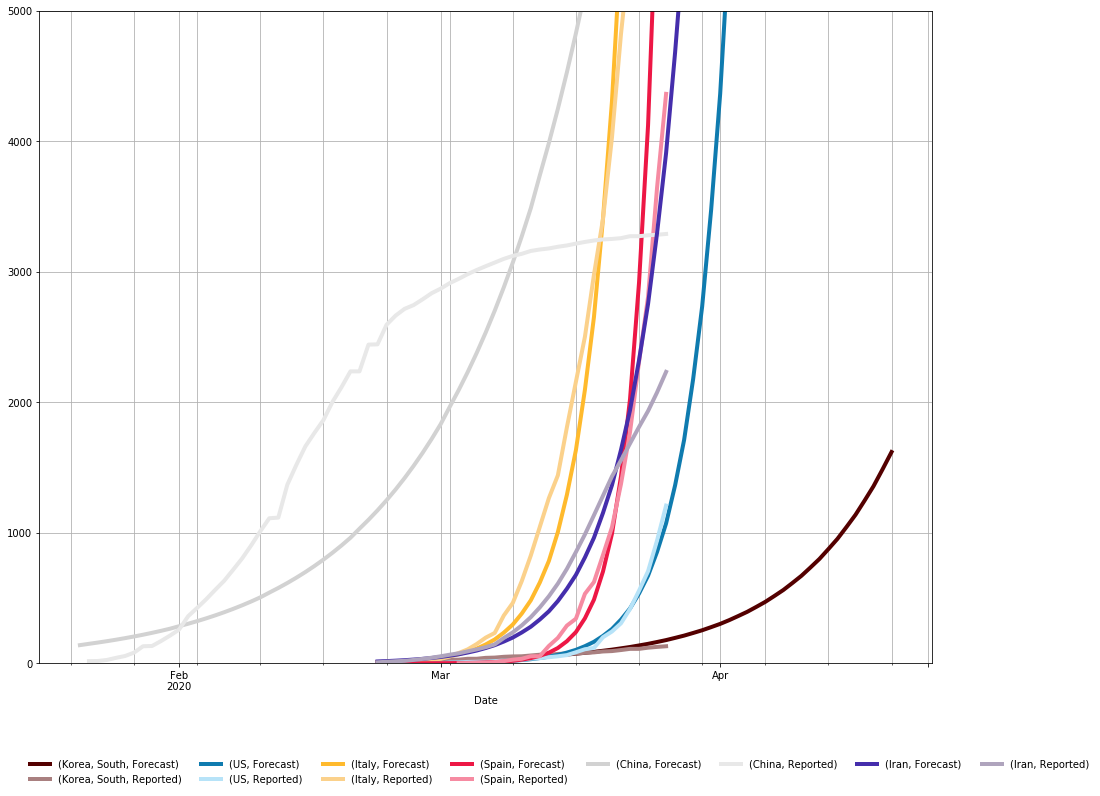

In [189]:
fig = plt.figure(1, figsize=[16,12])
ax = fig.add_subplot(111)
exp_forecast = exp_vs_reported(d_ts)
exp_forecast.plot(ax=ax, lw=4)
ax.set_ylim([0, 5000])
ax.grid('on', which='both')
legend_format(ax, cols=8, ypos=-0.2)


/home/humed/.local/lib/python3.5/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


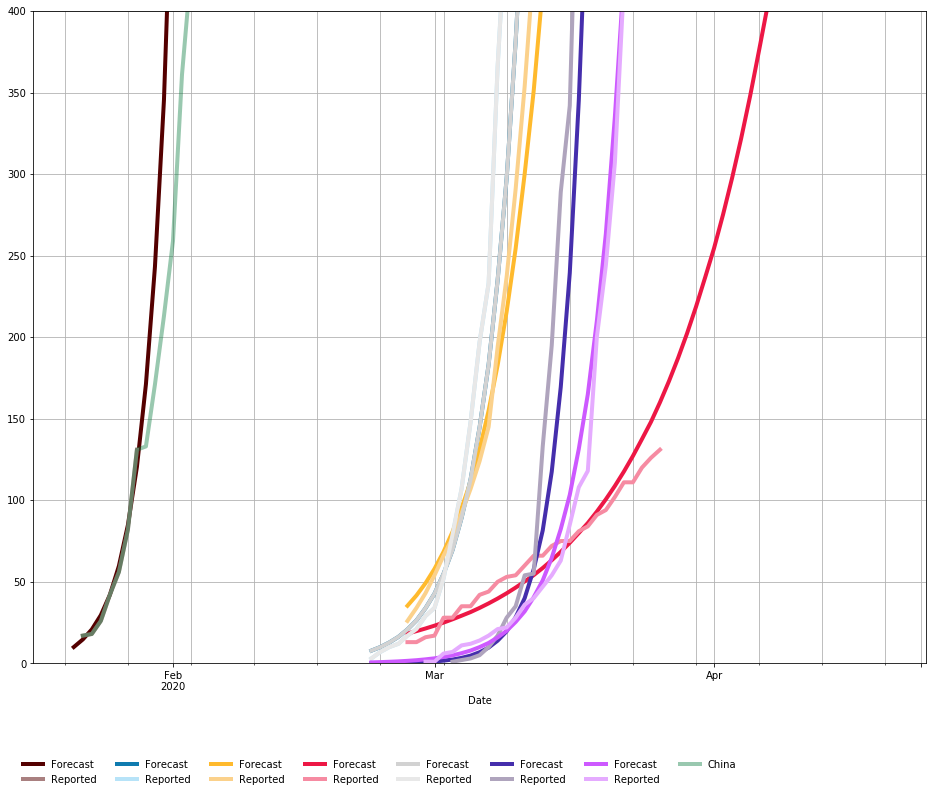

In [190]:
fig = plt.figure(1, figsize=[16,12])
ax = fig.add_subplot(111)
fit_exp(C_D[:7], start_date=datetime(2020,1,21)).plot(ax=ax, lw=4)
fit_exp(RoW_D2['Italy'], start_date=datetime(2020,2,23)).plot(ax=ax, lw=4, label='x')
fit_exp(RoW_D2['Iran'], start_date=datetime(2020,2,27)).plot(ax=ax, lw=4,)
fit_exp(RoW_D2['Korea, South'], start_date=datetime(2020,2,27)).plot(ax=ax, lw=4,)
fit_exp(RoW_D2['Italy'], start_date=datetime(2020,2,23)).plot(ax=ax, lw=4)
fit_exp(RoW_D2['Spain'], start_date=datetime(2020,2,23)).plot(ax=ax, lw=4)
fit_exp(RoW_D2['US'], start_date=datetime(2020,2,23)).plot(ax=ax, lw=4)
C_D.plot(ax=ax, lw=4, alpha=0.4)
ax.set_ylim([0, 400])
ax.grid('on', which='both')
legend_format(ax, cols=8, ypos=-0.2)

In [191]:
# need country population data - this data appears old so scale up
pop = pd.read_csv("pop.csv", index_col=0)
pop = (pop*7.8E9/pop.sum()).population

Countries_with_deaths = Cur_total_deaths[Cur_total_deaths>0].dropna().index
pop_total_with_deaths = pop.loc[Countries_with_deaths].sum()

Countries_with_more_than_100_deaths = Cur_total_deaths[Cur_total_deaths>100].dropna().index
pop_total_with_more_than_100_deaths = pop.loc[Countries_with_more_than_100_deaths].sum()



/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:6: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  


In [192]:
pop_total_with_more_than_100_deaths

880467581.8182541

[375000, 737522.0, 0.305, 10]
[375000, 737522.0, 0.305, 10]
[375000, 737522.0, 0.305, 10]
[375000, 737522.0, 0.305, 10]
[375000, 737522.0, 0.305, 10]
[375000, 737505.0, 0.305, 10]
[375000, 737505.0, 0.305, 10]
[375000, 737505.0, 0.305, 10]


/usr/local/lib/python3.5/dist-packages/scipy/optimize/_lsq/dogbox.py:225: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  newton_step = lstsq(J_free, -f)[0]


[20679.0, 737478.0, 1, 0.0]


/home/humed/.local/lib/python3.5/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


Text(2020-05-01 00:00:00, [30455.7610175], 'Forecast (6 days ago) - [NZ166])')

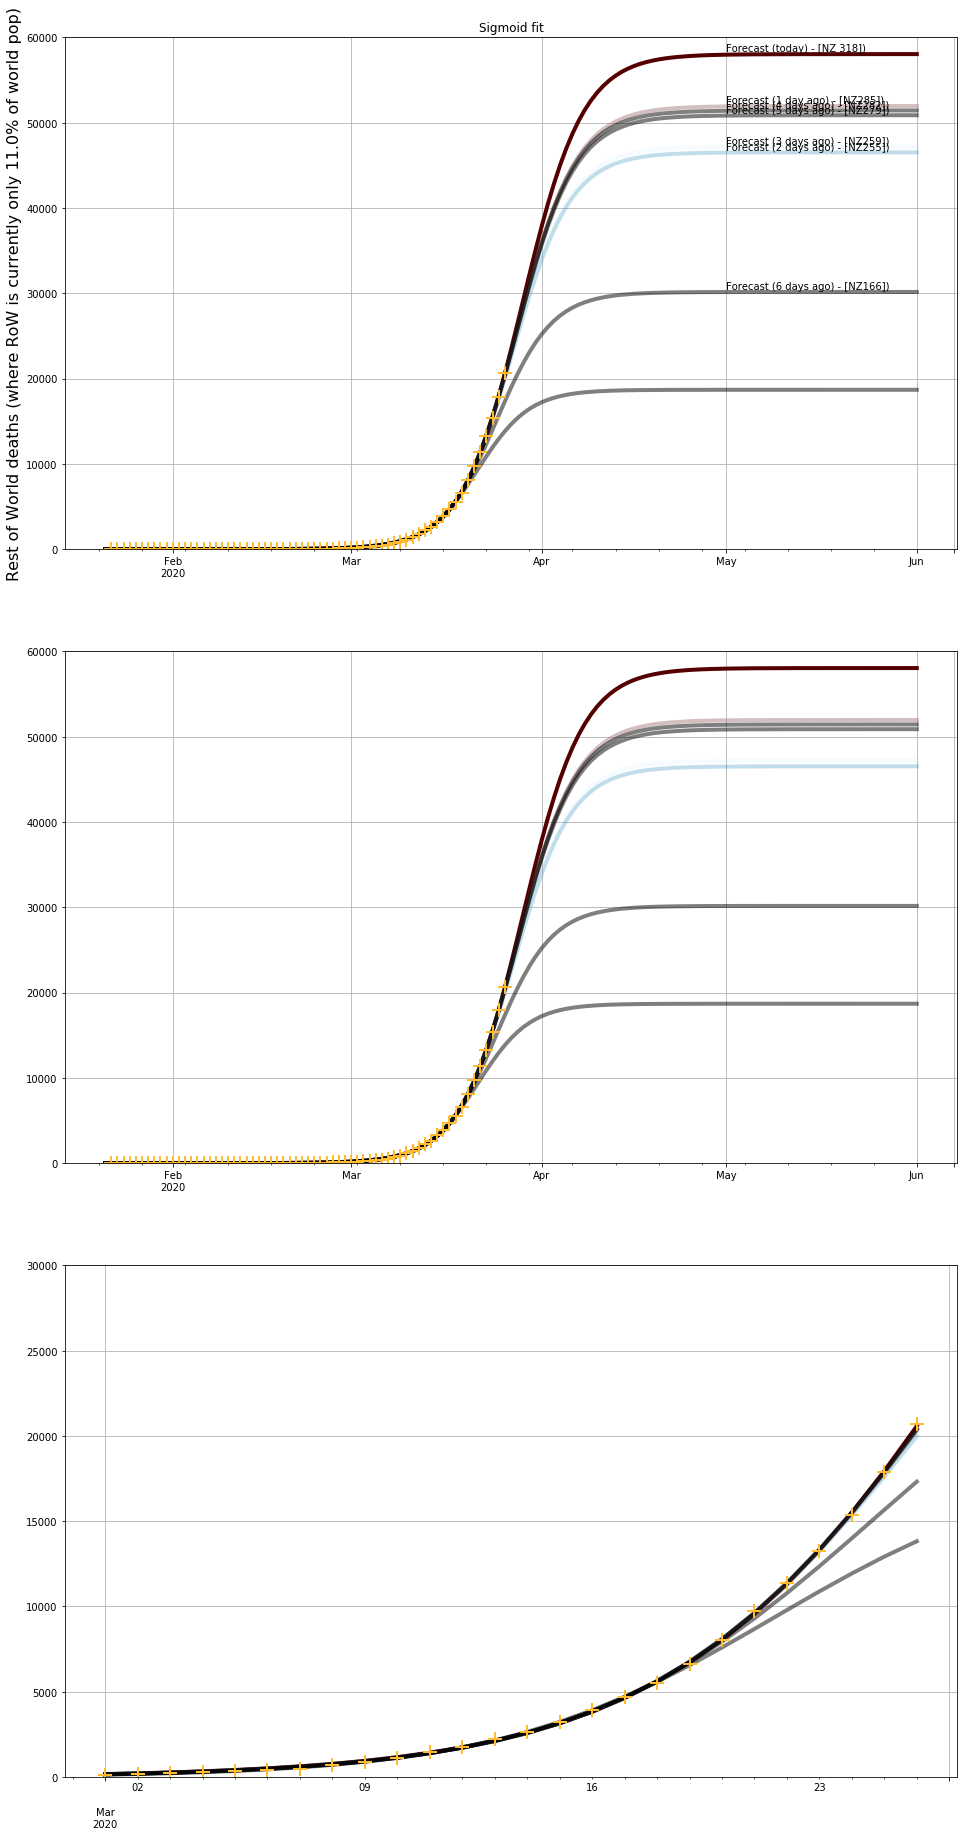

In [194]:
fig = plt.figure(1, figsize=[16,32])
ax = fig.add_subplot(311)
fs = fit_sigmoid(RoW_D, p0=[375000, date2num(datetime(2020,4,7)), 0.305, 10], end_date=datetime(2020,6,1)).Forecast
fsn1 = fit_sigmoid(RoW_D.iloc[:-1], p0=[375000, date2num(datetime(2020,4,7)), 0.305, 10], end_date=datetime(2020,6,1)).Forecast
fsn2 = fit_sigmoid(RoW_D.iloc[:-2], p0=[375000, date2num(datetime(2020,4,7)), 0.305, 10], end_date=datetime(2020,6,1)).Forecast
fsn3 = fit_sigmoid(RoW_D.iloc[:-3], p0=[375000, date2num(datetime(2020,4,7)), 0.305, 10], end_date=datetime(2020,6,1)).Forecast
fsn4 = fit_sigmoid(RoW_D.iloc[:-4], p0=[375000, date2num(datetime(2020,4,7)), 0.305, 10], end_date=datetime(2020,6,1)).Forecast
fsn5 = fit_sigmoid(RoW_D.iloc[:-5], p0=[375000, date2num(datetime(2020,3,21)), 0.305, 10], end_date=datetime(2020,6,1)).Forecast
fsn6 = fit_sigmoid(RoW_D.iloc[:-6], p0=[375000, date2num(datetime(2020,3,21)), 0.305, 10], end_date=datetime(2020,6,1)).Forecast
fsn7 = fit_sigmoid(RoW_D.iloc[:-7], p0=[375000, date2num(datetime(2020,3,21)), 0.305, 10], end_date=datetime(2020,6,1)).Forecast

fs.index = pd.to_datetime(fs.index)
fsn1.index = pd.to_datetime(fsn1.index)
fsn2.index = pd.to_datetime(fsn2.index)
fsn3.index = pd.to_datetime(fsn3.index)
fsn4.index = pd.to_datetime(fsn4.index)
fsn5.index = pd.to_datetime(fsn5.index)
fsn6.index = pd.to_datetime(fsn6.index)
fsn7.index = pd.to_datetime(fsn7.index)

fs.plot(ax=ax, lw=4)
fsn1.plot(ax=ax, lw=4, alpha=0.5)
fsn2.plot(ax=ax, lw=4, alpha=0.25)
fsn3.plot(ax=ax, lw=4, alpha=0.125)
fsn4.plot(ax=ax, lw=4, alpha=0.5, color='k')
fsn5.plot(ax=ax, lw=4, alpha=0.5, color='k')
fsn6.plot(ax=ax, lw=4, alpha=0.5, color='k')
fsn7.plot(ax=ax, lw=4, alpha=0.5, color='k')
ax.set_title('Sigmoid fit')
fs_r = fit_sigmoid(RoW_D).Reported
fs_r.index = pd.to_datetime(fs_r.index)
fs_r.plot(ax=ax, marker="+", lw=0, ms=14, mew=2)
grid('on')
ylim([0, 60000])
ax2 = fig.add_subplot(312)
(fs*1).plot(ax=ax2, lw=4)
fsn1.plot(ax=ax2, lw=4, alpha=0.5)
fsn2.plot(ax=ax2, lw=4, alpha=0.25)
fsn3.plot(ax=ax2, lw=4, alpha=0.125)
fsn4.plot(ax=ax2, lw=4, alpha=0.5, color='k')
fsn5.plot(ax=ax2, lw=4, alpha=0.5, color='k')
fsn6.plot(ax=ax2, lw=4, alpha=0.5, color='k')
fsn7.plot(ax=ax2, lw=4, alpha=0.5, color='k')

(fs_r*1).plot(ax=ax2, marker="+", lw=0, ms=14, mew=2)
grid('on')
ylim([0, 60000])

ax3 = fig.add_subplot(313)
fs["2020/3/1": "2020/3/26"].plot(ax=ax3, lw=4)
fsn1["2020/3/1": "2020/3/26"].plot(ax=ax3, lw=4, alpha=0.5)
fsn2["2020/3/1": "2020/3/26"].plot(ax=ax3, lw=4, alpha=0.25)
fsn3["2020/3/1": "2020/3/26"].plot(ax=ax3, lw=4, alpha=0.125)
fsn4["2020/3/1": "2020/3/26"].plot(ax=ax3, lw=4, alpha=0.5, color='k')
fsn5["2020/3/1": "2020/3/26"].plot(ax=ax3, lw=4, alpha=0.5, color='k')
fsn6["2020/3/1": "2020/3/26"].plot(ax=ax3, lw=4, alpha=0.5, color='k')
fsn7["2020/3/1": "2020/3/26"].plot(ax=ax3, lw=4, alpha=0.5, color='k')
fs_r["2020/3/1": "2020/3/26"].plot(ax=ax3, marker="+", lw=0, ms=14, mew=2)
grid('on')
ylim([0, 30000])

x_date = datetime(2020,5,1)
y_shift=300

pop_pc = 100*pop_total_with_more_than_100_deaths/pop.sum()

ax.set_ylabel('Rest of World deaths (where RoW is currently only ' + str(pop_pc.round()) + '% of world pop)', fontsize=16)

NZ_pop = 4822233
d = math.ceil(NZ_pop*fs.tail(1).values[0]/pop_total_with_more_than_100_deaths)
d1 = math.ceil(NZ_pop*fsn1.tail(1).values[0]/pop_total_with_more_than_100_deaths)
d2 = math.ceil(NZ_pop*fsn2.tail(1).values[0]/pop_total_with_more_than_100_deaths)
d3 = math.ceil(NZ_pop*fsn3.tail(1).values[0]/pop_total_with_more_than_100_deaths)
d4 = math.ceil(NZ_pop*fsn4.tail(1).values[0]/pop_total_with_more_than_100_deaths)
d5 = math.ceil(NZ_pop*fsn5.tail(1).values[0]/pop_total_with_more_than_100_deaths)
d6 = math.ceil(NZ_pop*fsn6.tail(1).values[0]/pop_total_with_more_than_100_deaths)
d7 = math.ceil(NZ_pop*fsn7.tail(1).values[0]/pop_total_with_more_than_100_deaths)

ax.text(x_date, fs.tail(1).values+y_shift, 'Forecast (today) - [NZ ' + str(d) + '])')
ax.text(x_date, fsn1.tail(1).values+y_shift, 'Forecast (1 day ago) - [NZ' + str(d1) + '])')
ax.text(x_date, fsn2.tail(1).values+y_shift, 'Forecast (2 days ago) - [NZ' + str(d2) + '])')
ax.text(x_date, fsn3.tail(1).values+y_shift, 'Forecast (3 days ago) - [NZ' + str(d3) + '])')
ax.text(x_date, fsn4.tail(1).values+y_shift, 'Forecast (4 days ago) - [NZ' + str(d4) + '])')
ax.text(x_date, fsn5.tail(1).values+y_shift, 'Forecast (5 days ago) - [NZ' + str(d5) + '])')
ax.text(x_date, fsn6.tail(1).values+y_shift, 'Forecast (6 days ago) - [NZ' + str(d6) + '])')
#ax.text(x_date, fsn7.tail(1).values+y_shift, 'Forecast (today) - [' + str(d7) + '])')


In [195]:
pop_total_with_more_than_100_deaths

880467581.8182541

In [196]:
# forecast NZ deaths 
d

318

/home/humed/.local/lib/python3.5/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


(1000, 17500)

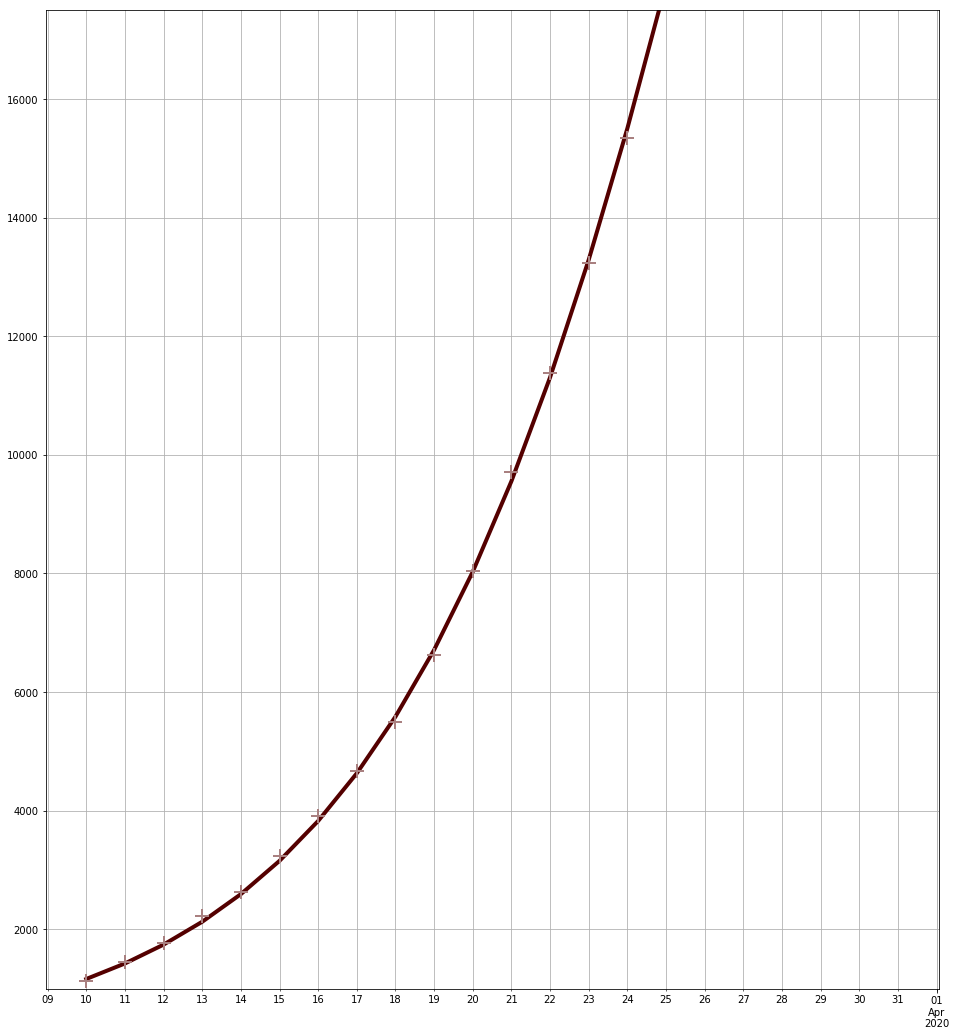

In [197]:
fig = plt.figure(1, figsize=[16,18])
ax = fig.add_subplot(111)
fs["2020/3/10":"2020/3/31"].plot(ax=ax, lw=4)
fs_r["2020/3/10": "2020/3/31"].plot(ax=ax, marker="+", lw=0, ms=14, mew=2)
grid('on', which='both')
ylim([1000, 17500])
# ax3.vlines(datetime(2020,3,10), ymin=0, ymax=2000, color='r')



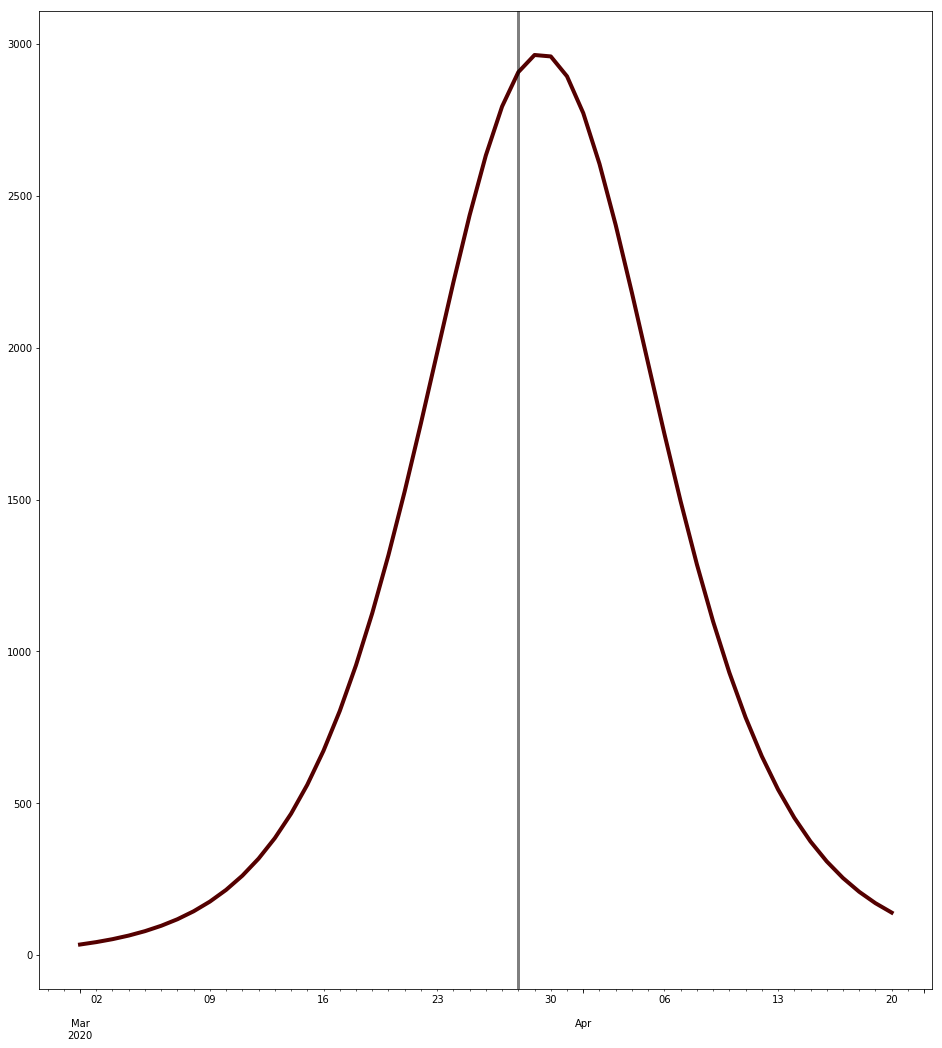

In [198]:
fig = plt.figure(1, figsize=[16,18])
ax = fig.add_subplot(111)
fs.diff()["2020/3/1": "2020/4/20"].plot(ax=ax, lw=4)
ax.axvline(datetime.now(), lw=3, color='k', alpha=0.5)

In [199]:
# Take a close look at Italy as looks like they are getting closer to the inflection point

Text(0, 0.5, 'Italian deaths per day')

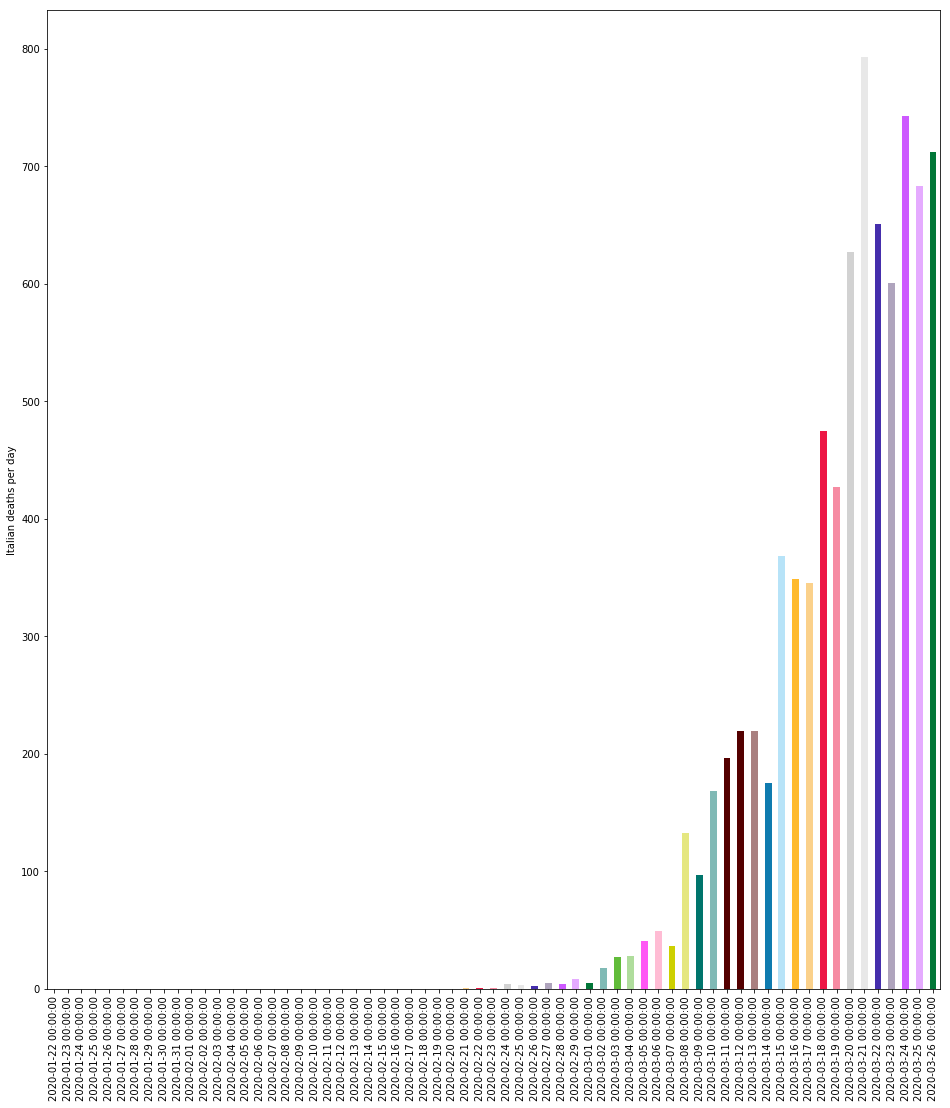

In [200]:
fig = plt.figure(1, figsize=[16,18])
ax = fig.add_subplot(111)
RoW_D3.diff()['Italy'].plot(kind='bar', ax=ax)
ax.set_ylabel('Italian deaths per day')

In [201]:

fs_Italy = fit_sigmoid(RoW_D3['Italy'], p0=[375000, date2num(datetime(2020,4,7)), 0.305, 10], end_date=datetime(2020,6,1))
fs_Spain = fit_sigmoid(RoW_D3['Spain'], p0=[375000, date2num(datetime(2020,4,7)), 0.305, 10], end_date=datetime(2020,6,1))
fs_Iran = fit_sigmoid(RoW_D3['Iran'], p0=[375000, date2num(datetime(2020,4,7)), 0.305, 10], end_date=datetime(2020,6,1))
fs_France = fit_sigmoid(RoW_D3['France'], p0=[375000, date2num(datetime(2020,4,1)), 0.305, 10], end_date=datetime(2020,6,1))
fs_US = fit_sigmoid(RoW_D3['US'], p0=[375000, date2num(datetime(2020,4,7)), 0.305, 10], end_date=datetime(2020,6,1))

[375000, 737522.0, 0.305, 10]
[375000, 737522.0, 0.305, 10]
[375000, 737522.0, 0.305, 10]
[375000, 737516.0, 0.305, 10]
[375000, 737522.0, 0.305, 10]


/usr/local/lib/python3.5/dist-packages/scipy/optimize/_lsq/dogbox.py:225: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  newton_step = lstsq(J_free, -f)[0]
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: overflow encountered in exp
  # Remove the CWD from sys.path while we load stuff.


In [202]:

fs_Italy_10_days_ago = fit_sigmoid(RoW_D3['Italy'][:-7], p0=[375000, date2num(datetime(2020,3,25)), 0.305, 10], end_date=datetime(2020,6,1))

[375000, 737509.0, 0.305, 10]


/usr/local/lib/python3.5/dist-packages/scipy/optimize/_lsq/dogbox.py:225: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  newton_step = lstsq(J_free, -f)[0]


/home/humed/.local/lib/python3.5/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


Text(0.5, 1.0, 'Italy (brown/yellow-7 days ago)/Spain (blue) - forecast COVID-19 deaths')

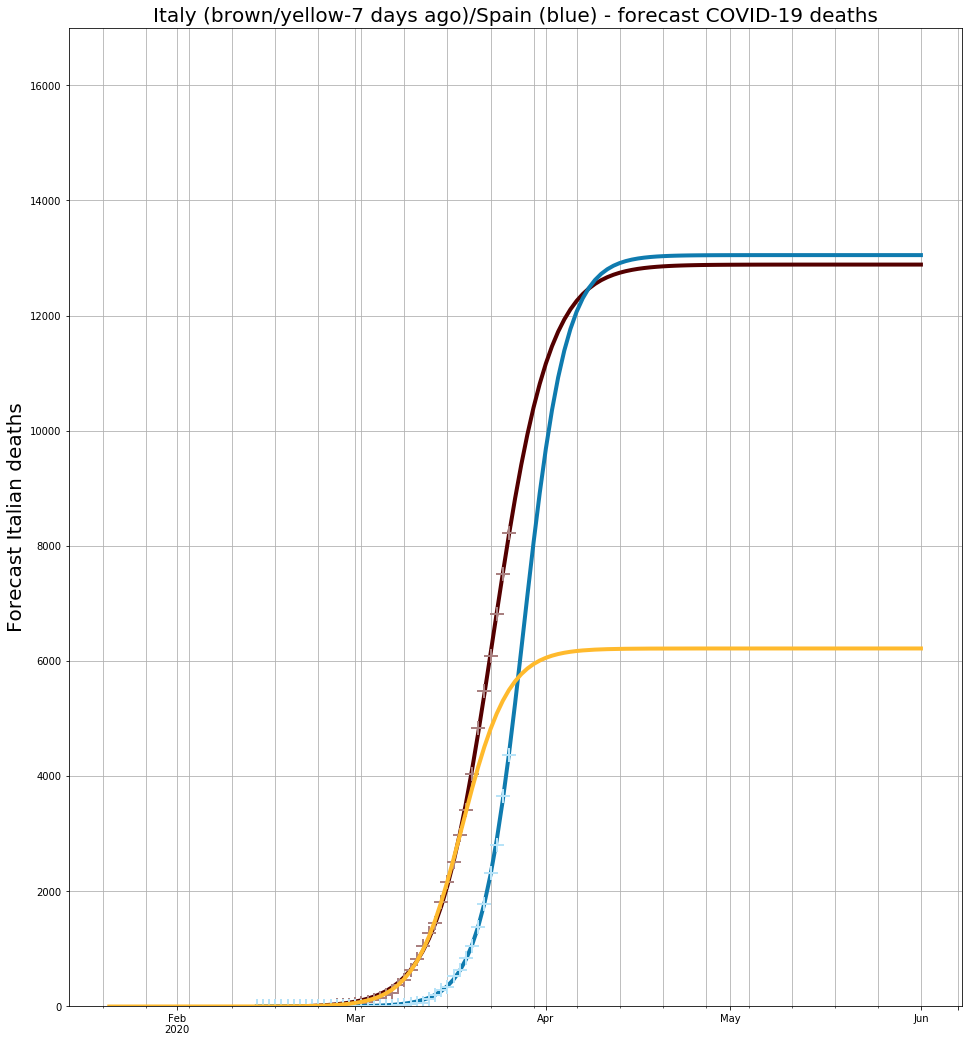

In [203]:
start_time="2020/2/14"
end_time="2020/6/1"

fig = plt.figure(1, figsize=[16,18])
ax = fig.add_subplot(111)
fs_Italy[start_time: end_time].Forecast.plot(ax=ax, lw=4)
fs_Italy[start_time: end_time].Reported.plot(ax=ax, marker="+", lw=0, ms=14, mew=2)
fs_Spain[start_time: end_time].Forecast.plot(ax=ax, lw=4)
fs_Spain[start_time: end_time].Reported.plot(ax=ax, marker="+", lw=0, ms=14, mew=2)
#fs_Iran[start_time: end_time].Forecast.plot(ax=ax, lw=4)
#fs_Iran[start_time: end_time].Reported.plot(ax=ax, marker="+", lw=0, ms=14, mew=2)
#fs_US[start_time: end_time].Forecast.plot(ax=ax, lw=4)
#fs_US[start_time: end_time].Reported.plot(ax=ax, marker="+", lw=0, ms=14, mew=2)
#fs_France[start_time: end_time].Forecast.plot(ax=ax, lw=4)
#fs_France[start_time: end_time].Reported.plot(ax=ax, marker="+", lw=0, ms=14, mew=2)
fs_Italy_10_days_ago.Forecast.plot(ax=ax, lw=4)
grid('on', which='both')
ylim([0, 17000])

ax.set_ylabel('Forecast Italian deaths', fontsize=20)
ax.set_title('Italy (brown/yellow-7 days ago)/Spain (blue) - forecast COVID-19 deaths', fontsize=20)

In [204]:

fs_row_daily_rate.Forecast.max()


5158.618913243115

In [205]:
#!git commit -a -m "Update"
#!git push djh master

In [206]:

pop['Spain']

51017116.21433477

In [207]:
fs_Spain.dropna().tail()

,Forecast,Reported
2020-03-22,1785.229247,1772.0
2020-03-23,2281.235033,2311.0
2020-03-24,2879.568387,2808.0
2020-03-25,3582.406721,3647.0
2020-03-26,4382.679809,4365.0


In [208]:
# Crude mortality rates per-million
1e6*fs_Italy.tail(1).values[0][0]/pop['Italy']


190.36460404603227

In [209]:
# Spain
1e6 * fs_Spain.tail(1).values[0][0]/pop['Spain']

255.78368971725007

In [210]:
# China / Hubei
1e6 * C_D_fitted.Forecast.tail(1).values[0]/60000000


54.22292778347846

In [211]:
#potential deaths in NZ based on current Italian curve
math.ceil(NZ_pop*fs_Italy.tail(1).values[0][0]/pop['Italy'])

918

In [212]:
#potential deaths in NZ based on current Spanish curve
math.ceil(NZ_pop*fs_Spain.tail(1).values[0][0]/pop['Spain'])

1234

In [213]:
# if the world follows Italy
math.ceil(fs_Italy.tail(1).values[0][0]/pop['Italy']*pop.sum())

1484844

In [214]:
# if the world follows Spain
math.ceil(fs_Italy.tail(1).values[0][0]/pop['Spain']*pop.sum())

1969959

In [215]:
fs_Italy.tail(1).values[0][0]

12884.82059548579

[375000, 737522.0, 0.305, 10]
[20679.0, 737478.0, 1, 0.0]


/usr/local/lib/python3.5/dist-packages/scipy/optimize/_lsq/dogbox.py:225: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  newton_step = lstsq(J_free, -f)[0]
/home/humed/.local/lib/python3.5/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


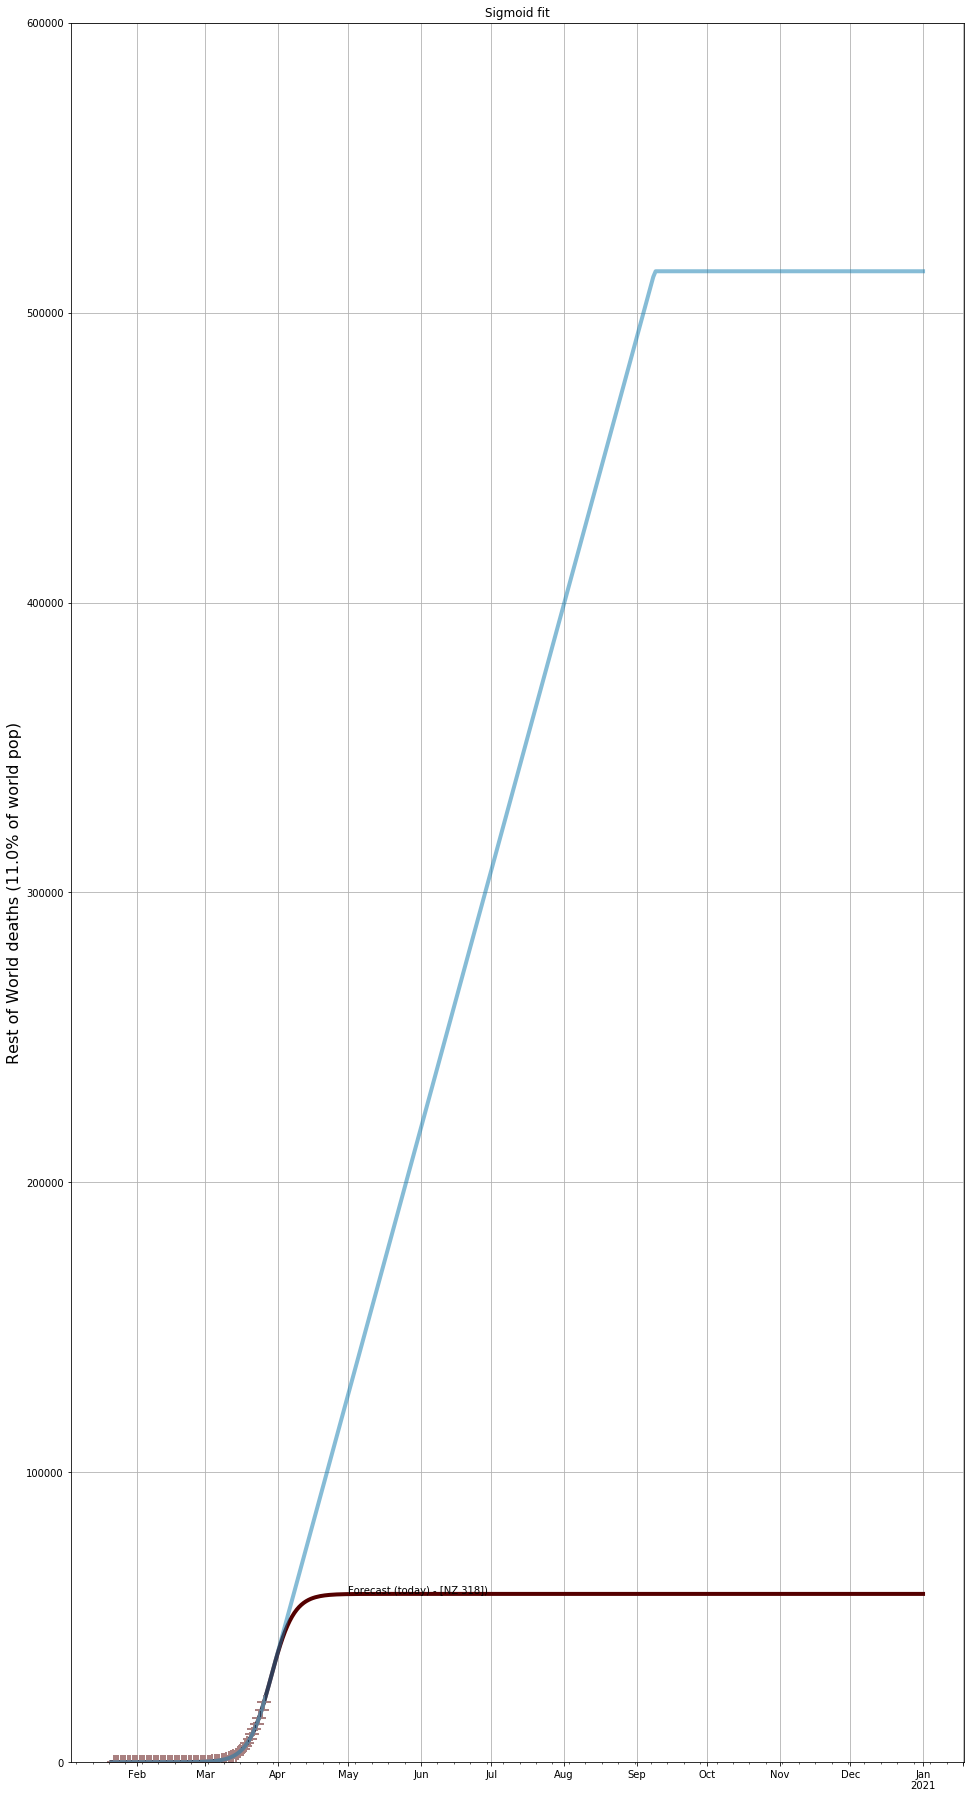

In [216]:
end_date = datetime(2021,1,1)

fig = plt.figure(1, figsize=[16,32])
ax = fig.add_subplot(111)
fs = fit_sigmoid(RoW_D, p0=[375000, date2num(datetime(2020,4,7)), 0.305, 10], 
                 end_date=end_date).Forecast
fs.index = pd.to_datetime(fs.index)

fs.plot(ax=ax, lw=4)
ax.set_title('Sigmoid fit')
fs_r = fit_sigmoid(RoW_D).Reported
fs_r.index = pd.to_datetime(fs_r.index)
fs_r.plot(ax=ax, marker="+", lw=0, ms=14, mew=2)
grid('on')
ylim([0, 600000])
x_date = datetime(2020,5,1)
y_shift=300

pop_pc = 100*pop_total_with_more_than_100_deaths/pop.sum()

ax.set_ylabel('Rest of World deaths (' + str(pop_pc.round()) + '% of world pop)', fontsize=16)

NZ_pop = 4822233
d = math.ceil(NZ_pop*fs.tail(1).values[0]/pop_total_with_more_than_100_deaths)

ax.text(x_date, fs.tail(1).values+y_shift, 'Forecast (today) - [NZ ' + str(d) + '])')

all_of_world = 1/(pop_pc/100.0)*fs.tail(1).values[0]
#ax.axhline(all_of_world, lw=4)


fs_linear = fs.copy()
lin_daily_diff_rate = fs.diff()
lin_daily_rate = lin_daily_diff_rate.max()
fs_linear[fs.diff().idxmax():]=lin_daily_rate
fs_linear[fs.diff().idxmax():]=fs_linear[datetime.now().date()]+fs_linear[fs.diff().idxmax():].cumsum()

fs_linear[fs_linear>all_of_world]=all_of_world
fs_linear.plot(ax=ax, lw=4, alpha=0.5)
grid('on')

In [217]:
all_of_world

514261.7114812907

In [218]:
all_of_world = 1/0.08*fs.tail(1).values[0]

In [219]:
fs_r.dropna().tail(2).diff()

2020-03-25       NaN
2020-03-26    2783.0
Name: Reported, dtype: float64

In [220]:
fs_linear = fs.copy()
lin_daily_rate = fs_linear.diff().max()
fs_linear[fs_linear>lin_daily_rate]=lin_daily_rate
fs_linear[fs_linear>=lin_daily_rate]=fs_linear[fs_linear>=lin_daily_rate].cumsum()



In [221]:
pop_pc

11.288045920746846

[275000, 737530.0, 0.305, 10]


/usr/local/lib/python3.5/dist-packages/scipy/optimize/_lsq/dogbox.py:225: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  newton_step = lstsq(J_free, -f)[0]
/home/humed/.local/lib/python3.5/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


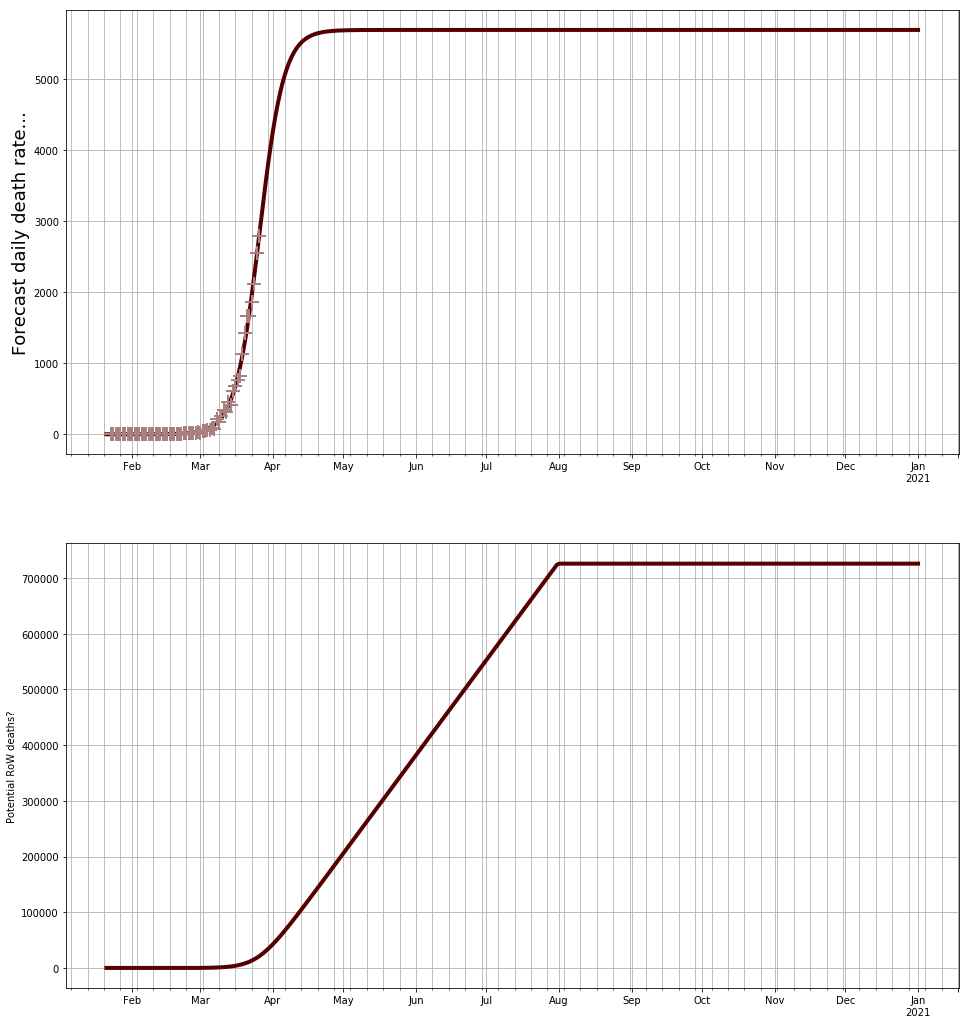

In [222]:
# what if we fit a sigmoid to the daily death rate... then intergrate this to cumulative deaths for RoW.
# If we assume that many distributed sigmoids/normal death curves cancel each other out, we could get a prolonged
# linear growth rate, or, constant death rate for some months until we reach the current forecast limit 
#(so far based on countries with over 100 deaths, or pop_pc % of world population)

end_date = datetime(2021,1,1)
fs_row_daily_rate = fit_sigmoid(RoW_D3.sum(axis=1).diff().dropna(), p0=[275000, date2num(datetime(2020,4,15)), 0.305, 10],
                                end_date=datetime(2021,1,1))

fig = plt.figure(1, figsize=[16,18])
ax = fig.add_subplot(211)
ax2 = fig.add_subplot(212)

fs_row_daily_rate.Forecast.plot(ax=ax, lw=4, )
fs_row_daily_rate.Reported.plot(ax=ax,marker="+", lw=0, ms=14, mew=2)

ax.grid('on', which='both')
ax.set_ylabel('Forecast daily death rate...', fontsize=18)
ax2.set_ylabel('Potential RoW deaths?')
fs_cumsum = fs_row_daily_rate.Forecast.cumsum()

#assume max limit from above estimate
fs_cumsum[fs_cumsum>all_of_world]=all_of_world
fs_cumsum.plot(ax=ax2, lw=4, )

grid('on', which='both')

In [230]:
# not fitting...

RoW_D3['US']["2020/3/18"]=np.nan
RoW_D4 = RoW_D3.interpolate()

spain_daily_rate = fit_sigmoid(RoW_D3['Spain'].diff().dropna(), p0=[195000, date2num(datetime(2020,4,5)), 0.305, 10],
                                end_date=datetime(2021,1,1))
italy_daily_rate = fit_sigmoid(RoW_D3['Italy'].diff().dropna(), p0=[195000, date2num(datetime(2020,4,5)), 0.305, 10],
                                end_date=datetime(2021,1,1))
US_daily_rate = fit_sigmoid(RoW_D4['US'].diff().dropna(), p0=[575000, date2num(datetime(2020,4,5)), 0.305, 10],
                                end_date=datetime(2021,1,1))
#germany_daily_rate = fit_sigmoid(RoW_D3['Germany'].diff().dropna(), p0=[375000, date2num(datetime(2020,5,25)), 0.305, 10],
#                                end_date=datetime(2021,1,1))
UK_daily_rate = fit_sigmoid(RoW_D3['United Kingdom'].diff().dropna(), p0=[275000, date2num(datetime(2020,4,15)), 0.305, 10],
                                end_date=datetime(2021,1,1))

[195000, 737520.0, 0.305, 10]
[195000, 737520.0, 0.305, 10]
[575000, 737520.0, 0.305, 10]
[275000, 737530.0, 0.305, 10]


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.5/dist-packages/scipy/optimize/_lsq/dogbox.py:225: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  newton_step = lstsq(J_free, -f)[0]
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: overflow encountered in exp
  # Remove the CWD from sys.path while we load stuff.


/home/humed/.local/lib/python3.5/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


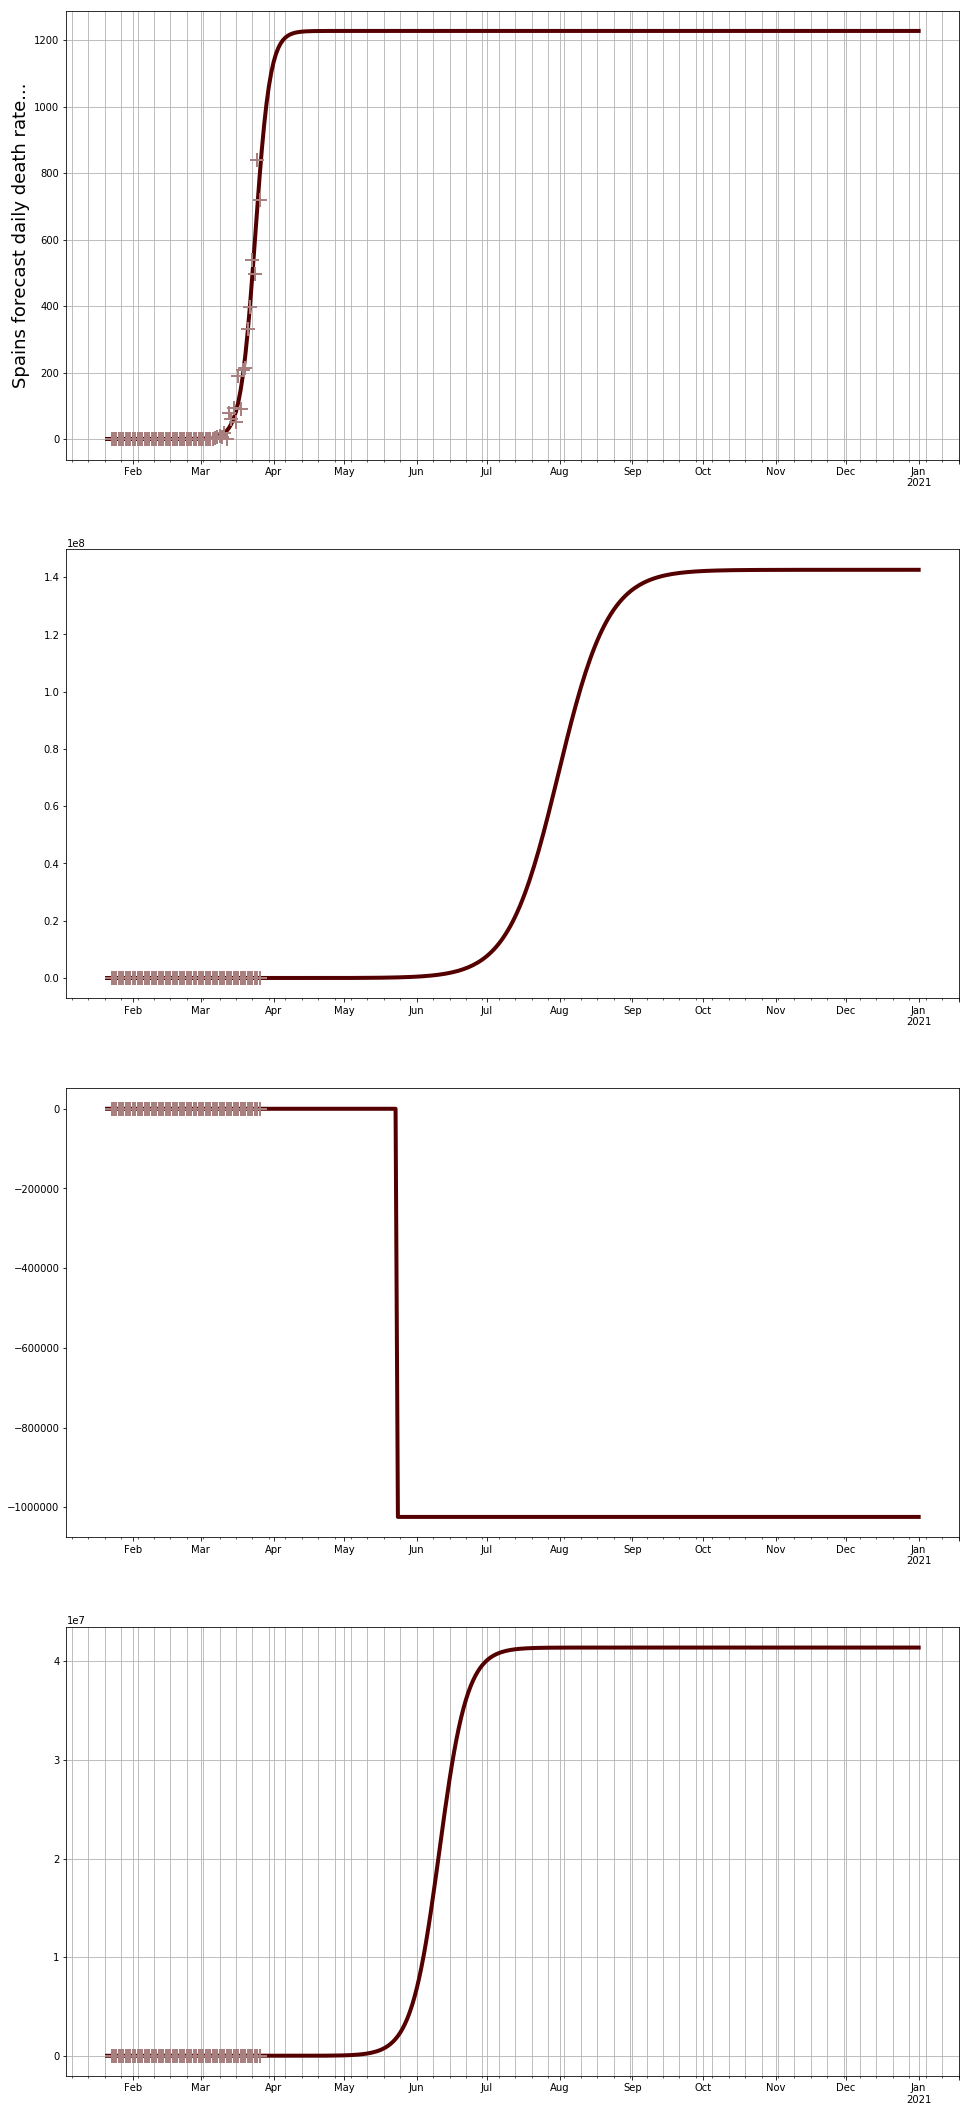

In [231]:

end_date = datetime(2021,1,1)

fig = plt.figure(1, figsize=[16,38])
ax = fig.add_subplot(411)
ax2 = fig.add_subplot(412)
ax3 = fig.add_subplot(413)
ax4 = fig.add_subplot(414)

spain_daily_rate.Forecast.plot(ax=ax, lw=4, )
spain_daily_rate.Reported.plot(ax=ax,marker="+", lw=0, ms=14, mew=2)

italy_daily_rate.Forecast.plot(ax=ax2, lw=4, )
italy_daily_rate.Reported.plot(ax=ax2,marker="+", lw=0, ms=14, mew=2)
 
US_daily_rate.Forecast.plot(ax=ax3, lw=4, )
US_daily_rate.Reported.plot(ax=ax3,marker="+", lw=0, ms=14, mew=2)

UK_daily_rate.Forecast.plot(ax=ax4, lw=4, )
UK_daily_rate.Reported.plot(ax=ax4,marker="+", lw=0, ms=14, mew=2)

ax.grid('on', which='both')
ax.set_ylabel('Spains forecast daily death rate...', fontsize=18)

grid('on', which='both')


In [106]:
RoW_D3.columns


Index(['Afghanistan', 'Albania', 'Algeria', 'Andorra', 'Argentina',
       'Australia', 'Austria', 'Azerbaijan', 'Bahrain', 'Bangladesh',
       'Belgium', 'Bosnia and Herzegovina', 'Brazil', 'Bulgaria',
       'Burkina Faso', 'Cabo Verde', 'Cameroon', 'Canada', 'Chile', 'Colombia',
       'Congo (Kinshasa)', 'Costa Rica', 'Croatia', 'Cuba', 'Cyprus',
       'Czechia', 'Denmark', 'Diamond Princess', 'Dominican Republic',
       'Ecuador', 'Egypt', 'Estonia', 'Finland', 'France', 'Gabon', 'Gambia',
       'Germany', 'Ghana', 'Greece', 'Guatemala', 'Guyana', 'Hungary',
       'Iceland', 'India', 'Indonesia', 'Iran', 'Iraq', 'Ireland', 'Israel',
       'Italy', 'Jamaica', 'Japan', 'Kazakhstan', 'Korea, South', 'Lebanon',
       'Lithuania', 'Luxembourg', 'Malaysia', 'Mauritius', 'Mexico', 'Moldova',
       'Montenegro', 'Morocco', 'Netherlands', 'Niger', 'Nigeria',
       'North Macedonia', 'Norway', 'Pakistan', 'Panama', 'Paraguay', 'Peru',
       'Philippines', 'Poland', 'Portugal', 'Ro